# EVALUATION OF TIMERS IN MICROPROCESSOR ESP32-C6
## GROUP 9

### Abstract

This project evaluates the timing accuracy and stability of software-based (soft) and hardware-based (hard) timers on the ESP32-C6 microcontroller. A simple toggling routine was implemented using both timer strategies to generate periodic events, with GPIO pin toggling serving as a measurable output. The actual timing of these events was captured and analyzed via serial logging and linear regression to estimate period, drift, and residual errors.

Results indicate that while both timers maintain a nominal frequency close to 2 Hz (500 ms period), the hard timer offers significantly lower timing jitter and mean absolute error, with residuals tightly bounded around the linear fit. In contrast, the soft timer exhibits systematic drift and higher variance in residuals, likely due to instruction-level timing variability and polling delays. Residual plots confirm this with periodic error patterns in the soft timer and minimal noise in the hard timer. These findings support the use of hardware timers in applications requiring precise and stable periodicity.



### 1. Methodology:
#### a. Preparation
- Python and Rust environment. Here I'm using Ubuntu 24.04, Python 3.12.3. Rust builds included in library.
- Create a circuit that have the microcontroller, two 4.7K resistors and a blue LED, a green LED

![image](test.jpg)

#### check if the LED works

![image](wiring.jpg)

#### real wiring. green to GPIO10, blue to GPIO7

- Code two versions of timer that is:


a. Soft timer: harness the time module of esp-hal, create a loop that, in sequence:
- toggle the LED
- set initial start of delay to now()
- make a while loop that instructs: if now is less than 500ms after initial, DO NOTHING, else loop back to normal

Actual Code:

```rust
// soft_timer.rs
#![no_std]
#![no_main]

use esp_hal::{
    clock::CpuClock,
    gpio::{Io, Level, Output, OutputConfig},
    main,
    time::{Duration, Instant},
};
use esp_println::println;
// You need a panic handler. Usually, you you would use esp_backtrace, panic-probe, or
// something similar, but you can also bring your own like this:
#[panic_handler]
fn panic(_: &core::panic::PanicInfo) -> ! {
    esp_hal::system::software_reset()
}

#[main]
fn main() -> ! {
    let config = esp_hal::Config::default().with_cpu_clock(CpuClock::max());
    let peripherals = esp_hal::init(config);

    // Set GPIO7 as an output, and set its state high initially.
    let mut led = Output::new(peripherals.GPIO7, Level::High, OutputConfig::default());

    loop {
        led.toggle();
        println!("LED toggled at {}", Instant::now());
        // Wait for half a second
        let delay_start = Instant::now();
        
        while delay_start.elapsed() < Duration::from_millis(500) {}
        
    }
}
```

b. Hard timer: harness the time module of embassy, create the loop that, in sequence:
- toggle the LED
- Do nothing, fire an interruption in 500ms then loop back

```rust
//! This is an example of running the embassy executor with multiple tasks
//! concurrently.

//% CHIPS: esp32 esp32c2 esp32c3 esp32c6 esp32h2 esp32s2 esp32s3
//% FEATURES: embassy esp-hal/unstable

#![no_std]
#![no_main]

use embassy_executor::Spawner;
use embassy_time::{Duration, Timer};
use esp_backtrace as _;
use esp_hal::timer::timg::TimerGroup;
use esp_hal::{
    clock::CpuClock,
    gpio::{Io, Level, Output, OutputConfig},
};
use esp_hal::time::Instant as Instant;

use esp_println::println;
/*
#[embassy_executor::task]
async fn run() {
    loop {
        esp_println::println!("Hello world from embassy using esp-hal-async!");
        Timer::after(Duration::from_millis(1_000)).await;
    }
}
*/
#[panic_handler]
fn panic(_: &core::panic::PanicInfo) -> ! {
    esp_hal::system::software_reset()
}

#[esp_hal_embassy::main]
async fn main(spawner: Spawner) {
    let config = esp_hal::Config::default().with_cpu_clock(CpuClock::max());
    let peripherals = esp_hal::init(config);
    println!("Init!");

    let timg0 = TimerGroup::new(peripherals.TIMG0);
    esp_hal_embassy::init(timg0.timer0);
    let mut led = Output::new(peripherals.GPIO10, Level::High, OutputConfig::default());
    // spawner.spawn(run()).ok();

    loop {
        led.toggle();
        println!("LED toggled at {}", Instant::now());
        Timer::after(Duration::from_millis(500)).await;
    }
}
```

#### b. Measure
- Open two terminals in the directory of the project.
- Use one to flash the code into the microprocessor
- One to monitor the serial output using cat, save to corresponding csv file output_soft.csv and output_hard.csv
    + flash to serial output using `cargo espflash flash --bin your-file-here`. DO NOT USE PARAMETER `--monitor` or else `cat` cannot read the serial
    + monitor by using command  `cat /dev/ttyACM0 > output_soft.csv` or `cat /dev/ttyUSB0 > output_hard.csv`
- When time reaches about 400 seconds (400_000_000 microseconds) shut the monitor.

#### c. Process the Data
- We write a function in Python that analyzes the time difference per cycle.
- The serial output looks like this: `LED toggled at 86175598 µs since epoch` so we need to parse the output microseconds.

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def parse_microseconds(file_path):
    times = []
    with open(file_path, 'r', encoding="utf-8") as f:
        for line in f:
            # Handle CSV or raw log format
            line = line.strip()
            if line == "":
                continue
            if re.match(r'^\d+$', line):  # Plain CSV number
                times.append(int(line))
            else:  # Text line like "LED toggled at 1234567 µs since epoch"
                match = re.search(r'(\d+)\s*µs', line)
                if match:
                    times.append(int(match.group(1)))
    return np.array(times)

def analyze_timer(times_us):
    n_cycles = np.arange(len(times_us)).reshape(-1, 1) # normalize to 2D array for sklearn
    times_us = times_us.reshape(-1, 1) 

    # Fit linear model: t = a*n + b
    model = LinearRegression()
    model.fit(n_cycles, times_us)

    predicted = model.predict(n_cycles)
    residuals = times_us - predicted

    print(f"Estimated period (a): {model.coef_[0][0]:.2f} µs")
    print(f"Estimated start time (b): {model.intercept_[0]:.2f} µs")
    print(f"Mean absolute error: {np.mean(np.abs(residuals)):.2f} µs")
    print(f"Standard deviation of residuals: {np.std(residuals):.2f} µs")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(n_cycles, times_us, label="Actual", marker='o', linestyle='--')
    plt.plot(n_cycles, predicted, label="Linear Fit", color='red')
    plt.title("Timer Ticks vs Epoch Time")
    plt.xlabel("Cycle Index (n)")
    plt.ylabel("Time since Epoch (µs)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot residuals
    plt.figure(figsize=(10, 4))
    plt.plot(n_cycles, residuals, marker='x', color='purple')
    plt.title("Residuals (Actual - Fitted)")
    plt.xlabel("Cycle Index (n)")
    plt.ylabel("Residual (µs)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main(file_path):
    times = parse_microseconds(file_path)
    return analyze_timer(times)


Let's see the results:

Estimated period (a): 500113.47 µs
Estimated start time (b): 1163428.93 µs
Mean absolute error: 238.54 µs
Standard deviation of residuals: 298.57 µs


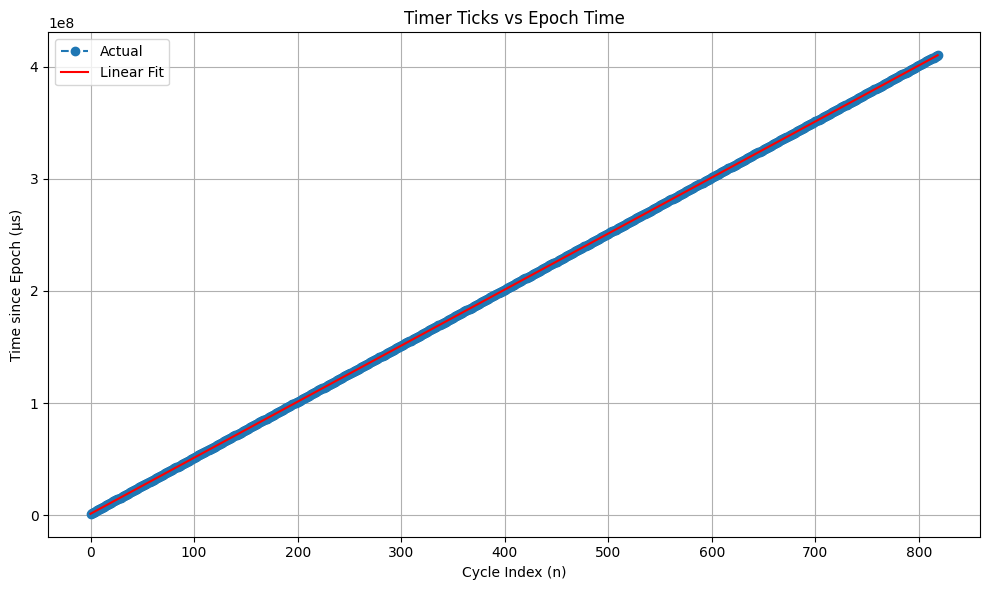

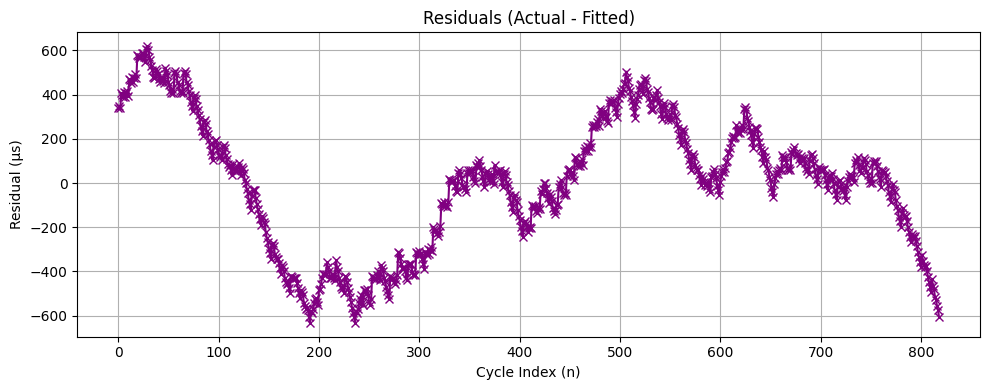

Estimated period (a): 500145.25 µs
Estimated start time (b): 1655774.94 µs
Mean absolute error: 19.86 µs
Standard deviation of residuals: 23.88 µs


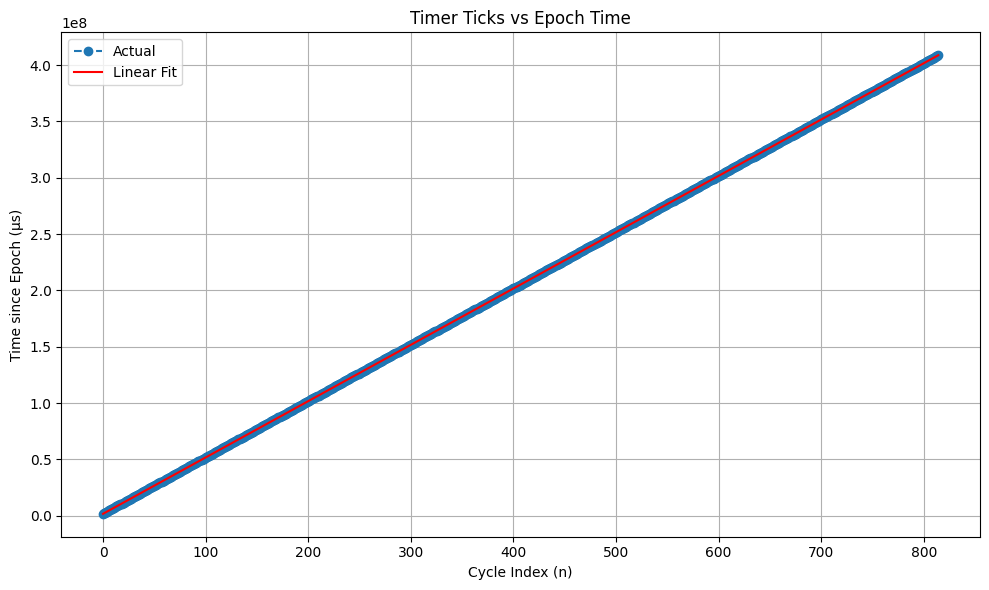

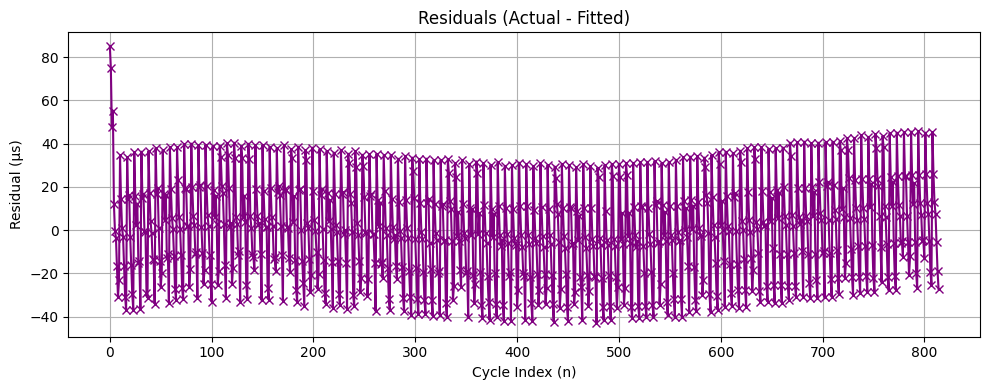

In [ ]:
main("output_soft.csv")
main("output_hard.csv") 

## 2. Results, Discussion
- Blinking video: [link](https://husteduvn-my.sharepoint.com/:v:/g/personal/hung_nd233960_sis_hust_edu_vn/ERfxBSqbcgZMnCoptaDuLiEBOR3HsRY_F7Z_F-qk6fwlgg?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=eIJpni)
- The results can be summarized in this table:

| Metric                         | Soft Timer        | Hard Timer        |
|-------------------------------|-------------------|-------------------|
| Estimated Period (µs)         | 500113.47 µs      | 500145.25 µs      |
| Estimated Start Time (µs)     | 1163428.93 µs     | 1655774.94 µs     |
| Mean Absolute Error (µs)      | 238.54 µs         | 19.86 µs          |
| Std. Deviation of Residuals   | 298.57 µs         | 23.88 µs          |

## Timer Residuals Analysis

### Soft Timer Residuals
**Observations:**
- Residuals show clear periodic drift up to ±600 µs.
- The pattern is systematic rather than random.
- Likely caused by accumulated timing inaccuracies such as:
  - Polling delays
  - Instruction timing variability
  - Interrupt interference
- Indicates low stability and high variance (standard deviation ≈ 298 µs).

**Implication:**
- Unsuitable for precise timing or applications that rely on stable intervals.



### Hard Timer Residuals
**Observations:**
- Residuals are confined within a narrow band (mostly within ±40 µs).
- Small, high-frequency noise present but no large-scale drift.
- Low mean error and standard deviation (≈ 23 µs).

**Implication:**
- Provides consistent and stable timing behavior.
- Well-suited for precise timing tasks such as signal generation, sampling, or control loops.



## Summary Table

| Feature                     | Soft Timer                          | Hard Timer                           |
|----------------------------|--------------------------------------|--------------------------------------|
| Residual amplitude         | ±600 µs (periodic drift)             | ±40 µs (tight band)                  |
| Noise profile              | Low-frequency, systematic error      | High-frequency, bounded jitter       |
| Stability over time        | Poor                                 | Excellent                            |
| Suitability for precision  | Not recommended                      | Recommended                          |
| Likely cause of error      | Accumulated loop/polling inaccuracy  | Minimal; likely due to clock rounding |


## 3. Explaination, why hard timer is better than soft timers? 

Let's look at the code carefully:

- In the soft timer, we call `Instant::now()`, then compare the elapsed time with delay_start.elapsed with a duration of 500ms
- In the hard timer, we call `Timer::after(Duration::from_millis(500)).await`

Let's see what they do. Let's look at the source code of Timer and Instant in the repo for esp-hal [link](https://docs.espressif.com/projects/rust/esp-hal/1.0.0-beta.0/esp32c6/esp_hal/index.html):

- `Instant` is a struct in module `time`: the implementation of `Instant::now()` and `Instant::now().elapsed()`:

```rust
#[inline]
```rust
impl Instant {
    /// Represents the moment the system booted.
    pub const EPOCH: Instant = Instant(InnerInstant::from_ticks(0));

    /// Returns the current instant.
    ///
    /// The counter won’t measure time in sleep-mode.
    ///
    /// The timer has a 1 microsecond resolution and will wrap after
    #[cfg_attr(esp32, doc = "36_558 years")]
    #[cfg_attr(esp32s2, doc = "7_311 years")]
    #[cfg_attr(not(any(esp32, esp32s2)), doc = "more than 7 years")]
    #[inline]
    pub fn now() -> Self {
        now()
    }

    #[inline]
    pub(crate) fn from_ticks(ticks: u64) -> Self {
        Instant(InnerInstant::from_ticks(ticks))
    }

    /// Returns the elapsed `Duration` since boot.
    #[inline]
    pub fn duration_since_epoch(&self) -> Duration {
        Self::EPOCH.elapsed()
    }

    /// Returns the elapsed `Duration` since this `Instant` was created.
    #[inline]
    pub fn elapsed(&self) -> Duration {
        Self::now() - *self
    }
}
```
and
```rust
fn now() -> Instant {

    #[cfg(not(esp32))]
    let (ticks, div) = {
        use crate::timer::systimer::{SystemTimer, Unit};
        // otherwise use SYSTIMER
        let ticks = SystemTimer::unit_value(Unit::Unit0);
        (ticks, (SystemTimer::ticks_per_second() / 1_000_000))
    };

    Instant::from_ticks(ticks / div)
}
```

- we clearly see that: `.elapsed()` is just a function that return the time difference between the `Instant` object `now` and itself from before.
- `now()` is evoked by a SYSTIMER that output the ticks and div and `now()` output the `ticks since epoch` divide by `ticks per second` we have microseconds.
- Wait, what are `ticks` and why are they related to SYSTIMER and microseconds ? 

Explaination:

Ticks represent the number of cycles the CPU clock has completed since the system was powered on. Because the CPU clock runs at a fixed frequency (like 80 MHz or 240 MHz), each tick corresponds to a precise, small amount of time. To measure elapsed time, the system uses a counter that increments in sync with these ticks. This counter starts from zero at boot and keeps counting upward, allowing the system to determine how much time has passed since startup. By knowing the tick frequency and reading the current counter value, software can convert ticks into meaningful time units like microseconds or milliseconds. This mechanism is the foundation of most system timers, both software and hardware, in microcontrollers like the ESP32.

Since the CPU literally have to waste time and logic to calculate different calculations, the output is delayed because of wasted time calculating and comparing time instances and wasted cycles of the loop.

We have to search what is SYSTIMER in ESP32-C6 datasheet.

In the datasheet, we see that The System Timer (SYSTIMER) in the ESP32-C6 chip is a 52-bit timer that can be used to generate tick
interrupts for the operating system or as a general timer to generate periodic or one-time interrupts. It is usually used for CPU clock.
